In [1]:
import numpy as np
import pandas as pd
import pickle
from scipy import stats

In [ ]:
print(aod.dtypes)
print(lur.dtypes)

In [2]:
aod_mod_file = '../data/MOD.csv'
aod_myd_file = '../data/MYD.csv'
lur_file = '../data/LUR.csv'

aod_mod = pd.read_csv(aod_mod_file, parse_dates=['date'])
print(aod_mod)
aod_myd = pd.read_csv(aod_myd_file, parse_dates=['date'])
print(aod_myd)
lur = pd.read_csv(lur_file, parse_dates=['date'])
print(lur)

          GRID_ID       date   aod_550  PIH        lat         lon
0               1 2013-01-01       NaN  0.0  30.072342 -124.494873
1               1 2013-01-02  0.070947  0.0  30.072342 -124.494873
2               1 2013-01-03       NaN  0.0  30.072342 -124.494873
3               1 2013-01-04       NaN  0.0  30.072342 -124.494873
4               1 2013-01-05       NaN  0.0  30.072342 -124.494873
...           ...        ...       ...  ...        ...         ...
22803005    31237 2014-12-27       NaN  0.0  48.977642 -100.011719
22803006    31237 2014-12-28       NaN  0.0  48.977642 -100.011719
22803007    31237 2014-12-29       NaN  0.0  48.977642 -100.011719
22803008    31237 2014-12-30       NaN  0.0  48.977642 -100.011719
22803009    31237 2014-12-31       NaN  0.0  48.977642 -100.011719

[22803010 rows x 6 columns]
          GRID_ID       date   aod_550  PIH        lat         lon
0               1 2013-01-01       NaN  0.0  30.072342 -124.494873
1               1 2013-01-02  0.0

In [ ]:
data = np.loadtxt('../aug_24_cmaq_preds.csv', skiprows=1, usecols=3, delimiter=',', dtype='str_')
data = np.where(data != 'NA', data, '0')
data = data.astype('float')
print((~np.isnan(data)).nonzero())

In [3]:
wrf = np.loadtxt('../wrf_grid.csv', skiprows=1, usecols=(1,2), delimiter=',')
print(wrf.shape)
wrf_lats = wrf[:,1]
wrf_lons = wrf[:,0]
grid = np.mgrid[49:30:-0.12,-125:-100:0.12]

def get_dists(latlon):
	var1 = np.cos(wrf_lats*np.pi/180) * np.cos(latlon[0]*np.pi/180) * np.cos((latlon[1]-wrf_lons)*np.pi/180)
	var2 = np.sin(wrf_lats*np.pi/180) * np.sin(latlon[0]*np.pi/180)
	var3 = var1 + var2
	return 3959 * np.arccos(var3)


dists = np.apply_along_axis(get_dists, 0, grid)
wrf2grid_map = np.argmin(dists, axis=0)
#gridded_data = data[grid2wrf_map]

(31237, 2)


In [ ]:
grid2 = np.mgrid[49:30:-0.1,-125:-100:0.1]

dists2 = np.apply_along_axis(get_dists, 0, grid2)
grid2wrf_map2 = np.argmin(dists2, axis=0)
gridded_data2 = data[grid2wrf_map2]

In [ ]:
print(data.shape)

print(gridded_data.shape)
print(grid.shape)

In [78]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
os.environ['PROJ_LIB'] = '/Users/Jeffrey/anaconda3/envs/stats/share/proj'
from mpl_toolkits.basemap import Basemap,maskoceans,interp,shiftgrid

In [125]:
m = Basemap(projection='cyl',llcrnrlon=-125,llcrnrlat=30,urcrnrlon=-100,urcrnrlat=49)

cmap = plt.get_cmap('Greens', lut=20)
clevs = np.arange(0, 100, 5)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(30,20))
x, y = m(wrf_lons, wrf_lats)
orig = m.contourf(x, y, data, clevs, extend='max', cmap=cmap, ax=ax[0], tri=True)
cbar1 = m.colorbar(orig, ticks = np.arange(0, 100, 5), ax=ax[0])
cbar1.ax.set_ylabel('$\mu$g mm$^{-3}$', weight='bold', name='Calibri', size=18, style='italic')
m.drawcoastlines(linewidth=3, ax=ax[0])
ax[0].set_title('CMAQ DS Predictions', fontdict = {'fontsize' : 30})

x, y = m(grid[1], grid[0])
cs2 = m.contourf(x, y, gridded_data, clevs, extend='max', cmap=cmap, ax=ax[1])
cbar2 = m.colorbar(cs2, ticks = np.arange(0, 100, 5), ax=ax[1])
cbar2.ax.set_ylabel('$\mu$g mm$^{-3}$', weight='bold', name='Calibri', size=18, style='italic')
m.drawcoastlines(linewidth=3, ax=ax[1])
ax[1].set_title('CMAQ DS Predictions (regridded $\Delta=0.12$)', fontdict = {'fontsize' : 30})

x, y = m(grid2[1], grid2[0])
cs3 = m.contourf(x, y, gridded_data2, clevs, extend='max', cmap=cmap, ax=ax[2])
cbar3 = m.colorbar(cs3, ticks = np.arange(0, 100, 5), ax=ax[2])
cbar3.ax.set_ylabel('$\mu$g mm$^{-3}$', weight='bold', name='Calibri', size=18, style='italic')
m.drawcoastlines(linewidth=3, ax=ax[2])
ax[2].set_title('CMAQ DS Predictions (regridded $\Delta=0.1$)', fontdict = {'fontsize' : 30})

In [4]:
aod = aod_mod.merge(aod_myd.drop(columns=['lat', 'lon']), left_on=['date', 'GRID_ID'], right_on=['date', 'GRID_ID'], how='left')
aod['aod_550'] = aod[['aod_550_x', 'aod_550_y']].mean(axis=1)
aod['pih'] = aod[['PIH_x', 'PIH_y']].mean(axis=1)
aod.describe()

,GRID_ID,aod_550_x,PIH_x,lat,lon,aod_550_y,PIH_y,aod_550,pih
count,2.280301e+07,1.081065e+07,1.998801e+07,2.280301e+07,2.280301e+07,3.266973e+06,6.205349e+06,1.157899e+07,2.059504e+07
mean,1.561900e+04,1.198824e-01,6.647209e-01,3.907867e+01,-1.124913e+02,1.090856e-01,1.034531e+00,1.202897e-01,6.963391e-01
std,9.017345e+03,9.466997e-02,1.586218e+01,5.475065e+00,7.212180e+00,9.162974e-02,2.339124e+01,9.428945e-02,1.601601e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,3.000000e+01,-1.249999e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.810000e+03,5.709028e-02,0.000000e+00,3.429488e+01,-1.187380e+02,4.989132e-02,0.000000e+00,5.756368e-02,0.000000e+00
50%,1.561900e+04,9.509649e-02,0.000000e+00,3.886874e+01,-1.124916e+02,8.630952e-02,0.000000e+00,9.552174e-02,0.000000e+00
75%,2.342800e+04,1.584333e-01,0.000000e+00,4.375418e+01,-1.062453e+02,1.454657e-01,0.000000e+00,1.594681e-01,0.000000e+00
max,3.123700e+04,3.742000e+00,2.285628e+03,4.899974e+01,-1.000001e+02,3.690000e+00,2.231001e+03,3.742000e+00,2.285628e+03


In [5]:
d = lur.merge(aod, left_on=['date', 'Grid_Cell'], right_on=['date', 'GRID_ID'], sort=True)
print(d)

          Grid_Cell       date    T_2m_Avg  Dwt_2m_Avg  Ws_10m_Avg  \
0                 1 2013-01-01  289.785004  286.942902    4.506738   
1                 2 2013-01-01  289.768555  286.952606    4.500871   
2                 3 2013-01-01  289.774170  286.945587    4.494429   
3                 4 2013-01-01  289.762939  286.962921    4.503541   
4                 5 2013-01-01  289.710785  287.009064    4.515438   
...             ...        ...         ...         ...         ...   
22803005      31233 2014-12-31  259.341553  254.615280    6.263021   
22803006      31234 2014-12-31  259.272583  254.562668    7.244837   
22803007      31235 2014-12-31  259.498749  254.753677    7.380472   
22803008      31236 2014-12-31  259.641022  254.756165    6.342928   
22803009      31237 2014-12-31  259.747681  254.725235    7.241125   

          Wdir_10m_Avg       Pmsl_Avg  Veg_Avg  PM_FRM_mod  Albedo_560  ...  \
0           348.483063  102353.875000      0.0    1.248798         NaN  ...   
1

In [74]:
d1 = d.drop(['Grid_Cell','GRID_ID', 'lat', 'lon', 'aod_550_y', 'aod_550_x', 'PIH_x', 'PIH_y'], axis=1)
print(d1.columns)
d1 = d1.loc[~d1['aod_550'].isnull()]
data_ndjf = d1.loc[(d1['date'].dt.month >= 11) | (d1['date'].dt.month <= 2)]
print(data_ndjf.columns)
data_ndjf = data_ndjf.drop(['date'], axis=1)
data_jas = d1.loc[(d1['date'].dt.month >= 7) & (d1['date'].dt.month <= 9)]
data_jas = data_jas.drop(['date'], axis=1)


Index(['date', 'T_2m_Avg', 'Dwt_2m_Avg', 'Ws_10m_Avg', 'Wdir_10m_Avg',
       'Pmsl_Avg', 'Veg_Avg', 'PM_FRM_mod', 'Albedo_560', 'HGT', 'Dist', 'RH',
       'PBLH', 'FRP', 'NH3', 'SO2', 'NOx', 'Pop_den', 'aod_550', 'pih'],
      dtype='object')
Index(['date', 'T_2m_Avg', 'Dwt_2m_Avg', 'Ws_10m_Avg', 'Wdir_10m_Avg',
       'Pmsl_Avg', 'Veg_Avg', 'PM_FRM_mod', 'Albedo_560', 'HGT', 'Dist', 'RH',
       'PBLH', 'FRP', 'NH3', 'SO2', 'NOx', 'Pop_den', 'aod_550', 'pih'],
      dtype='object')


(array([5.12609e+05, 9.00030e+05, 6.11310e+05, 3.26331e+05, 1.87841e+05,
        1.07951e+05, 6.02110e+04, 3.32640e+04, 1.94360e+04, 1.18250e+04,
        6.53700e+03, 2.25800e+03, 4.47000e+02, 3.23000e+02, 2.87000e+02,
        1.89000e+02, 1.40000e+02, 1.44000e+02, 1.12000e+02, 9.50000e+01,
        7.30000e+01, 6.50000e+01, 4.60000e+01, 4.70000e+01, 3.20000e+01,
        4.00000e+01, 3.40000e+01, 2.70000e+01, 2.90000e+01, 3.50000e+01,
        2.90000e+01, 3.80000e+01, 1.70000e+01, 3.10000e+01, 2.20000e+01,
        1.90000e+01, 2.40000e+01, 1.20000e+01, 2.40000e+01, 1.80000e+01,
        1.80000e+01, 1.10000e+01, 1.10000e+01, 1.60000e+01, 9.00000e+00,
        9.00000e+00, 7.00000e+00, 1.30000e+01, 1.20000e+01, 7.00000e+00,
        6.00000e+00, 8.00000e+00, 7.00000e+00, 3.00000e+00, 2.00000e+00,
        4.00000e+00, 3.00000e+00, 2.00000e+00, 4.00000e+00, 1.00000e+00,
        2.00000e+00, 5.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 3.00000e+00, 1.00000e+00, 0.00

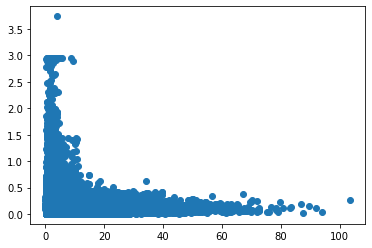

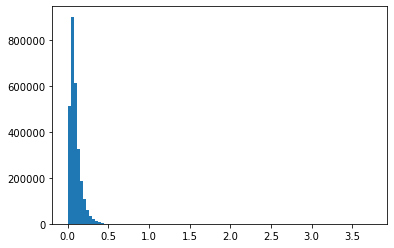

In [75]:
plt.figure()
plt.scatter(data_ndjf.PM_FRM_mod, data_ndjf.aod_550)
plt.figure()
plt.hist(data_ndjf.aod_550, bins=100)

In [30]:
print(data_ndjf.isnull().sum())

T_2m_Avg             0
Dwt_2m_Avg           0
Ws_10m_Avg           0
Wdir_10m_Avg         0
Pmsl_Avg             0
Veg_Avg              0
PM_FRM_mod           0
Albedo_560      374591
HGT                  0
Dist                 0
RH                   0
PBLH                 0
FRP                  0
NH3                  0
SO2                  0
NOx                  0
Pop_den              0
aod_550              0
pih                  0
dtype: int64


In [83]:
data_ndjf_anom = (data_ndjf - np.mean(data_ndjf.values, axis=0)) / np.std(data_ndjf.values, axis=0)
print(data_ndjf_anom)
data_jas_anom = (data_jas - np.mean(data_jas.values, axis=0)) / np.std(data_jas.values, axis=0)

          T_2m_Avg  Dwt_2m_Avg  Ws_10m_Avg  Wdir_10m_Avg  Pmsl_Avg   Veg_Avg  \
1         1.508646    2.004562    0.268031      0.914869  1.506838 -1.009042   
9         1.458366    2.056728    0.282439      0.834048  1.505940 -1.009042   
11        1.453568    2.070012    0.303974      0.810395  1.506369 -1.009042   
12        1.442327    2.061873    0.307368      0.805518  1.506177 -1.009042   
15        1.521324    1.972498    0.269614      0.916819  1.505858 -1.009042   
...            ...         ...         ...           ...       ...       ...   
22795156 -1.979552   -0.802662    0.115844      1.907592 -1.363919  0.373333   
22795157 -2.007238   -0.830658   -0.482385     -0.270355 -1.415904  0.677160   
22795655 -2.363688   -1.384953    1.077947     -0.244022  0.359026 -0.942399   
22796889 -2.454005   -1.494473    0.733515     -0.292593  0.510742 -0.942399   
22797065 -2.413772   -1.507488    0.721214     -0.261912  0.510327 -0.942399   

          PM_FRM_mod  Albedo_560       

In [55]:
data_ndjf_anom.columns

Index(['T_2m_Avg', 'Dwt_2m_Avg', 'Ws_10m_Avg', 'Wdir_10m_Avg', 'Pmsl_Avg',
       'Veg_Avg', 'PM_FRM_mod', 'Albedo_560', 'HGT', 'Dist', 'RH', 'PBLH',
       'FRP', 'NH3', 'SO2', 'NOx', 'Pop_den', 'aod_550', 'pih'],
      dtype='object')

In [189]:
# y = data_ndjf_anom.aod_550.values
# E = np.ones((data_ndjf_anom.shape[0], 2))
# #E[:,1:] = data_ndjf_anom.drop(['aod_550'], axis=1).values
# E[:,1] = data_ndjf_anom.PM_FRM_mod
# print(y, E)
# xhat = np.linalg.inv(E.T @ E) @ (E.T @ y)
# print(xhat)


predictors = data_ndjf_anom.drop(['aod_550', 'Albedo_560', 'T_2m_Avg', 'Dwt_2m_Avg', 'Ws_10m_Avg', 'Wdir_10m_Avg', 'Pmsl_Avg', 'Veg_Avg'], axis=1)
predictors = pd.concat([predictors, data_ndjf_anom[['Veg_Avg', 'T_2m_Avg', 'Dwt_2m_Avg', 'Ws_10m_Avg', 'Wdir_10m_Avg']]], axis=1)
cols = np.concatenate((['bias'], predictors.columns.values))
predictors = predictors.values

kMax = predictors.shape[1]+1

AIC = np.ones((kMax,))*np.nan
BIC = np.ones((kMax,))*np.nan
se2 = np.ones((kMax,))*np.nan

for k in range(1,kMax+1):
    print(cols[k-1])
    y = data_ndjf_anom.aod_550.values
    E = np.ones((data_ndjf_anom.shape[0], k))
    if k != 1:
        E[:,1:] = predictors[:,:k-1]
    xhat = np.linalg.inv(E.T @ E) @ (E.T @ y)
    #print(xhat[-1])
    
    n = y.size # Number of samples
    
    #=======================================================================
    # AIC and BIC formula from Wilks
    #=======================================================================
    if k == 1:
        se2[k-1] = ((n-1)/(n-2))*(1-xhat**2)*np.nanvar(y)
    else:
        se2[k-1] = se2[k-2]*(1-xhat[-1]**2)
        #print(se2[k-2]*(1-xhat[-1]**2))
    
    AIC[k-1] = n*np.log( n*se2[k-1]/(n-k-1) ) + 2*(k+1)
    BIC[k-1] = n*np.log( n*se2[k-1]/(n-k-1) ) + (k+1)*np.log(n)

print(AIC, BIC)

minOrder = np.where(AIC == AIC.min())[0][0]
print('The smallest AIC score is: {:5.2f}, which corresponds to the AR-{} model.'\
    .format(AIC.min(),minOrder+1))

minOrder = np.where(BIC == BIC.min())[0][0]
print('The smallest BIC score is: {:5.2f}, which corresponds to the AR-{} model.'\
    .format(BIC.min(),minOrder+1))

for v, x in zip(cols, xhat):
    print(v, x)

bias
PM_FRM_mod
HGT
Dist
RH
PBLH
FRP
NH3
SO2
NOx
Pop_den
pih
Veg_Avg
T_2m_Avg
Dwt_2m_Avg
Ws_10m_Avg
Wdir_10m_Avg
[ 7.00000126e+00 -2.38012138e+02 -1.84219007e+04 -1.89750518e+04
 -2.11999581e+05 -2.50806753e+05 -2.50805401e+05 -2.55752040e+05
 -2.55766699e+05 -2.56379016e+05 -2.56734258e+05 -2.58579887e+05
 -2.62104018e+05 -3.27951663e+05 -4.07208192e+05 -4.10781498e+05
 -4.37003934e+05] [ 3.26775502e+01 -1.99495814e+02 -1.83705456e+04 -1.89108579e+04
 -2.11922549e+05 -2.50716882e+05 -2.50702691e+05 -2.55636491e+05
 -2.55638311e+05 -2.56237790e+05 -2.56580193e+05 -2.58412983e+05
 -2.61924275e+05 -3.27759082e+05 -4.07002771e+05 -4.10563238e+05
 -4.36772836e+05]
The smallest AIC score is: -437003.93, which corresponds to the AR-17 model.
The smallest BIC score is: -436772.84, which corresponds to the AR-17 model.
bias -4.144129891106324e-15
PM_FRM_mod 0.01710674004974884
HGT 0.03342043364159317
Dist -0.07998413164826824
RH 0.3313316435066389
PBLH 0.10634199546745601
FRP -0.00042956190351

Text(0, 0.5, 'BIC')

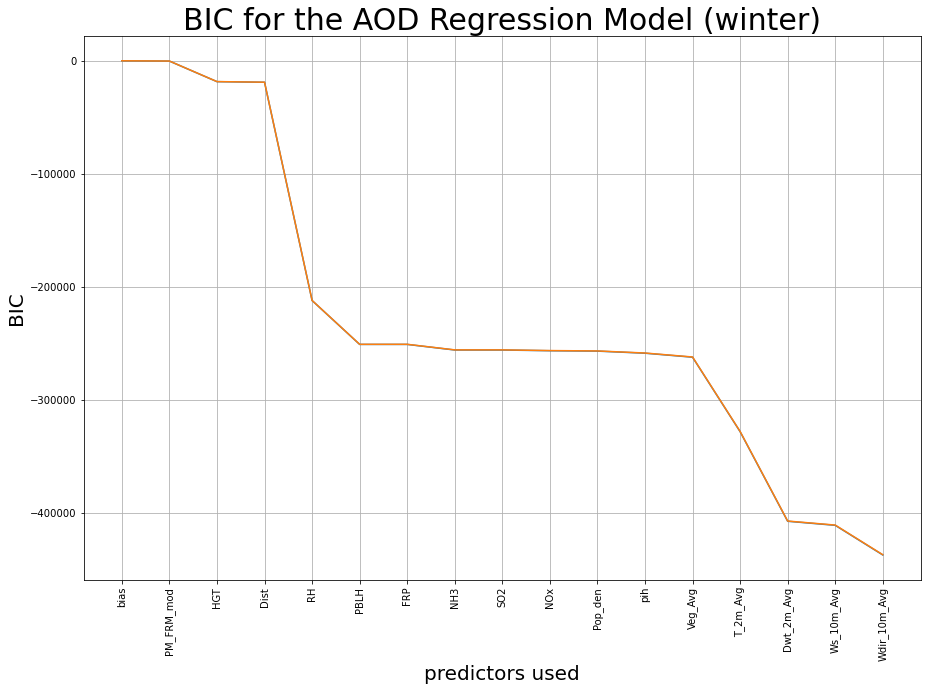

In [182]:
plt.figure(figsize=(15,10))
plt.plot(AIC, label='AIC')
plt.plot(BIC, label='BIC')
plt.xticks(np.arange(cols.size), cols, rotation='vertical')
plt.grid(True)
plt.title('BIC for the AOD Regression Model (winter)', size=30)
plt.xlabel('predictors used', size=20)
plt.ylabel('BIC', size=20)

In [ ]:
for c, a in zip(cols, xhat):
    print(c, a)

bias -4.144129891106324e-15
PM_FRM_mod 0.01710674004974884
HGT 0.03342043364159317
Dist -0.07998413164826824
RH 0.3313316435066389
PBLH 0.10634199546745601
FRP -0.0004295619035140537
NH3 0.047499825377473326
SO2 0.0017468525429392328
NOx -0.016010748165387854
Pop_den 0.017721790624526043
pih 0.026986952692610755
Veg_Avg -0.03869506970286749
T_2m_Avg -0.03984670143032287
Dwt_2m_Avg -0.17074425567523044
Ws_10m_Avg 0.04545187767052419
Wdir_10m_Avg -0.09685896395846336


In [190]:
predictors = data_jas_anom.drop(['aod_550', 'Albedo_560', 'T_2m_Avg', 'Dwt_2m_Avg', 'Ws_10m_Avg', 'Wdir_10m_Avg', 'Pmsl_Avg', 'Veg_Avg'], axis=1)
predictors = pd.concat([predictors, data_jas_anom[['Veg_Avg', 'T_2m_Avg', 'Dwt_2m_Avg', 'Ws_10m_Avg', 'Wdir_10m_Avg']]], axis=1)
cols = np.concatenate((['bias'], predictors.columns.values))
predictors = predictors.values

kMax = predictors.shape[1]+1

AIC = np.ones((kMax,))*np.nan
BIC = np.ones((kMax,))*np.nan
se2 = np.ones((kMax,))*np.nan

for k in range(1,kMax+1):
    print(cols[k-1])
    y = data_jas_anom.aod_550.values
    E = np.ones((data_jas_anom.shape[0], k))
    if k != 1:
        E[:,1:] = predictors[:,:k-1]
    xhat = np.linalg.inv(E.T @ E) @ (E.T @ y)
    #print(xhat[-1])
    
    n = y.size # Number of samples
    
    #=======================================================================
    # AIC and BIC formula from Wilks
    #=======================================================================
    if k == 1:
        se2[k-1] = ((n-1)/(n-2))*(1-xhat**2)*np.nanvar(y)
    else:
        se2[k-1] = se2[k-2]*(1-xhat[-1]**2)
        #print(se2[k-2]*(1-xhat[-1]**2))
    
    AIC[k-1] = n*np.log( n*se2[k-1]/(n-k-1) ) + 2*(k+1)
    BIC[k-1] = n*np.log( n*se2[k-1]/(n-k-1) ) + (k+1)*np.log(n)

print(AIC, BIC)

minOrder = np.where(AIC == AIC.min())[0][0]
print('The smallest AIC score is: {:5.2f}, which corresponds to the AR-{} model.'\
    .format(AIC.min(),minOrder+1))

minOrder = np.where(BIC == BIC.min())[0][0]
print('The smallest BIC score is: {:5.2f}, which corresponds to the AR-{} model.'\
    .format(BIC.min(),minOrder+1))

for v, x in zip(cols, xhat):
    print(v, x)

bias
PM_FRM_mod
HGT
Dist
RH
PBLH
FRP
NH3
SO2
NOx
Pop_den
pih
Veg_Avg
T_2m_Avg
Dwt_2m_Avg
Ws_10m_Avg
Wdir_10m_Avg
[ 7.00000097e+00 -2.59762768e+04 -3.11064392e+04 -3.43139439e+04
 -6.78058076e+04 -6.78513628e+04 -7.16728208e+04 -7.17984660e+04
 -7.18020451e+04 -7.27089551e+04 -7.28525776e+04 -6.86723041e+05
 -6.87757613e+05 -8.42518590e+05 -1.10363372e+06 -1.10534679e+06
 -1.10535972e+06] [ 3.32031755e+01 -2.59369720e+04 -3.10540328e+04 -3.42484359e+04
 -6.77271981e+04 -6.77596516e+04 -7.15680081e+04 -7.16805517e+04
 -7.16710292e+04 -7.25648377e+04 -7.26953586e+04 -6.86552720e+05
 -6.87574191e+05 -8.42322067e+05 -1.10342410e+06 -1.10512406e+06
 -1.10512389e+06]
The smallest AIC score is: -1105359.72, which corresponds to the AR-17 model.
The smallest BIC score is: -1105124.06, which corresponds to the AR-16 model.
bias -9.403488103192195e-16
PM_FRM_mod 0.0539016043947118
HGT 0.1365121799821144
Dist -0.015914295896095963
RH -0.04182288498658404
PBLH 0.0345517630820768
FRP 0.0130167765818

Text(0, 0.5, 'BIC')

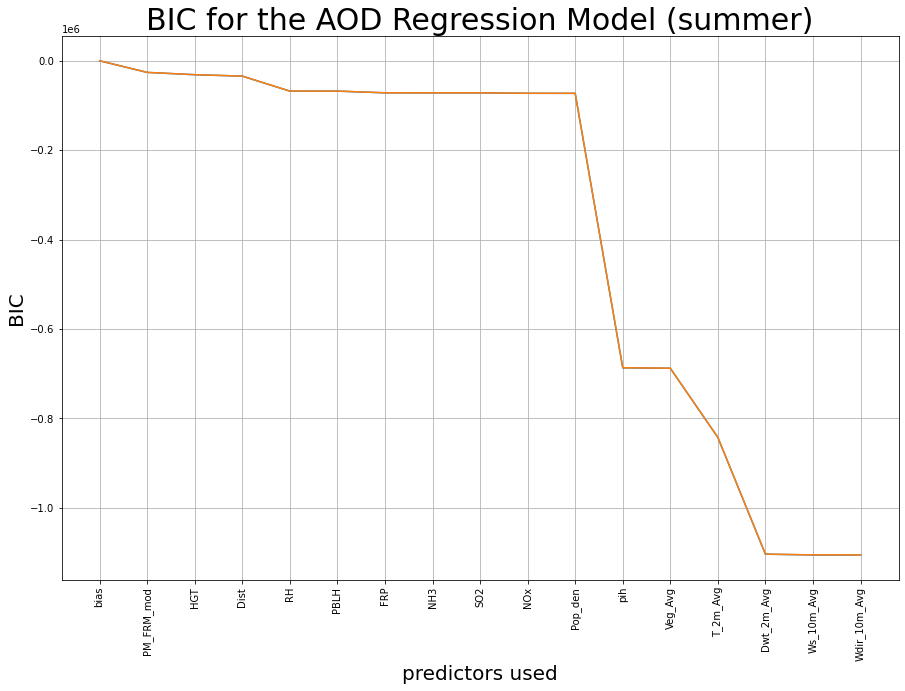

In [184]:
plt.figure(figsize=(15,10))
plt.plot(AIC, label='AIC')
plt.plot(BIC, label='BIC')
plt.xticks(np.arange(cols.size), cols, rotation='vertical')
plt.grid(True)
plt.title('BIC for the AOD Regression Model (summer)', size=30)
plt.xlabel('predictors used', size=20)
plt.ylabel('BIC', size=20)

In [112]:
monthly_avg = d.groupby([d.date.dt.month, d.Grid_Cell]).aod_550.aggregate(np.nanmean).values.reshape((-1,31237))
print(monthly_avg.shape)

(12, 31237)


In [115]:
loc = np.where(~np.any(np.isnan(monthly_avg[[0,1,6,7,8,9,10,11]]), axis=0))[0]
print(loc.size)

26046


In [121]:
test = d.date.dt.month.loc[(d['date'].dt.month >= 7) & (d['date'].dt.month <= 9)].values.reshape((-1,31237))[:,0] - 1
monthly_avg[test][:,loc].shape

(184, 26046)

In [155]:
alpha = 0.05

data_1 = d.loc[(d['date'].dt.month >= 7) & (d['date'].dt.month <= 9)].aod_550.values.reshape((-1,31237))[:,loc]
data_2 = d.loc[(d['date'].dt.month >= 10) | (d['date'].dt.month <= 2)].aod_550.values.reshape((-1,31237))[:,loc]
# month_1 = d.date.dt.month.loc[(d['date'].dt.month >= 7) & (d['date'].dt.month <= 10)].values.reshape((-1,31237))[:,0] - 1
# month_2 = d.date.dt.month.loc[(d['date'].dt.month >= 11) | (d['date'].dt.month <= 2)].values.reshape((-1,31237))[:,0] - 1
# anom_1 = data_1 - monthly_avg[month_1][:,loc]
# anom_2 = data_2 - monthly_avg[month_2][:,loc]
combine = np.append(data_1, data_2, axis=0)

print(data_1.shape, data_2.shape)

comp1 = np.nanmean(data_1, axis=0)
comp2 = np.nanmean(data_2, axis=0)
compdiff = comp1 - comp2

size_1 = anom_1.shape[0]
mcs = np.zeros((1000,data_1.shape[1]))
for j in range(1000):
    if j % 500 == 0:
        print(j)
    np.random.shuffle(combine)
    mcs[j] = np.nanmean(combine[:size_1], axis=0) - np.nanmean(combine[size_1:], axis=0)
    
pval = np.array([stats.percentileofscore(mcs[:,i],compdiff[i])/100. for i in range(compdiff.size)])
sig = (pval < alpha / 2) | (pval > 1 - alpha / 2)
pct_points = sig.sum() / sig.size
print(pct_points)


(184, 26046) (302, 26046)
0
500
0.8594793826307302


In [149]:
#np.count_nonzero(np.isnan(comp2))
pval

array([0.5074, 0.4992, 0.4944, ..., 0.5002, 0.4982, 0.5008])

In [156]:
comp1s = np.zeros((32,loc.size))
comp1s[0] = comp1
comp2s = np.zeros((32,loc.size))
comp2s[0] = comp2
compdiffs = np.zeros((32,loc.size))
compdiffs[0] = compdiff
sigs = np.zeros((32,loc.size))
sigs[0] = sig
pct_pointss = [pct_points]
for i in range(1,32):
    data_1 = d.loc[((d['date'].dt.month >= 7) & (d['date'].dt.month <= 9)) | ((d['date'].dt.month == 10) & (d['date'].dt.day <= i))].aod_550.values.reshape((-1,31237))[:,loc]
    data_2 = d.loc[((d['date'].dt.month >= 11) | (d['date'].dt.month <= 2)) | ((d['date'].dt.month == 10) & (d['date'].dt.day > i))].aod_550.values.reshape((-1,31237))[:,loc]
    # month_1 = d.date.dt.month.loc[((d['date'].dt.month >= 7) & (d['date'].dt.month <= 9)) | ((d['date'].dt.month == 10) & (d['date'].dt.day <= i))].values.reshape((-1,31237))[:,0] - 1
    # month_2 = d.date.dt.month.loc[((d['date'].dt.month >= 11) | (d['date'].dt.month <= 2)) | ((d['date'].dt.month == 10) & (d['date'].dt.day > i))].values.reshape((-1,31237))[:,0] - 1
    # anom_1 = data_1 - monthly_avg[month_1][:,loc]
    # anom_2 = data_2 - monthly_avg[month_2][:,loc]
    combine = np.append(data_1, data_2, axis=0)

    print(data_1.shape, data_2.shape)

    comp1 = np.nanmean(data_1, axis=0)
    comp2 = np.nanmean(data_2, axis=0)
    compdiff = comp1 - comp2
    
    comp1s[i] = comp1
    comp2s[i] = comp2
    compdiffs[i] = compdiff

    size_1 = data_1.shape[0]
    mcs = np.zeros((1000,data_1.shape[1]))
    for j in range(1000):
        if j % 500 == 0:
            print(j)
        np.random.shuffle(combine)
        mcs[j] = np.nanmean(combine[:size_1], axis=0) - np.nanmean(combine[size_1:], axis=0)

    pval = np.array([stats.percentileofscore(mcs[:,i],compdiff[i])/100. for i in range(compdiff.size)])
    sig = (pval < alpha / 2) | (pval > 1 - alpha / 2)
    sigs[i] = sig
    pct_points = sig.sum() / sig.size
    pct_pointss.append(pct_points)

(186, 26046) (300, 26046)
0
500
(188, 26046) (298, 26046)
0
500
(190, 26046) (296, 26046)
0
500
(192, 26046) (294, 26046)
0
500
(194, 26046) (292, 26046)
0
500
(196, 26046) (290, 26046)
0
500
(198, 26046) (288, 26046)
0
500
(200, 26046) (286, 26046)
0
500
(202, 26046) (284, 26046)
0
500
(204, 26046) (282, 26046)
0
500
(206, 26046) (280, 26046)
0
500
(208, 26046) (278, 26046)
0
500
(210, 26046) (276, 26046)
0
500
(212, 26046) (274, 26046)
0
500
(214, 26046) (272, 26046)
0
500
(216, 26046) (270, 26046)
0
500
(218, 26046) (268, 26046)
0
500
(220, 26046) (266, 26046)
0
500
(222, 26046) (264, 26046)
0
500
(224, 26046) (262, 26046)
0
500
(226, 26046) (260, 26046)
0
500
(228, 26046) (258, 26046)
0
500
(230, 26046) (256, 26046)
0
500
(232, 26046) (254, 26046)
0
500
(234, 26046) (252, 26046)
0
500
(236, 26046) (250, 26046)
0
500
(238, 26046) (248, 26046)
0
500
(240, 26046) (246, 26046)
0
500
(242, 26046) (244, 26046)
0
500
(244, 26046) (242, 26046)
0
500
(246, 26046) (240, 26046)
0
500


Text(0.5, 1.0, 'AOD Compositing Significance vs. Date Cutoff')

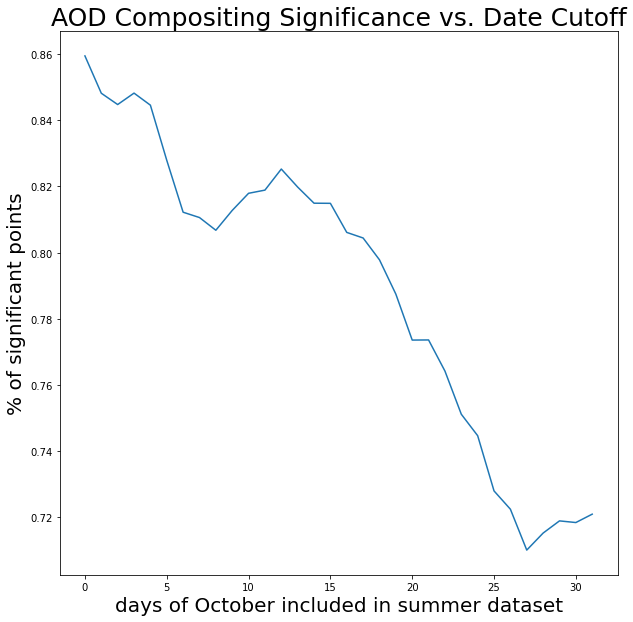

In [172]:
plt.figure(figsize=(10,10))
plt.plot(pct_pointss)
plt.xlabel('days of October included in summer dataset', size=20)
plt.ylabel('% of significant points', size=20)
plt.title('AOD Compositing Significance vs. Date Cutoff', size=25)

C:\Users\Jeffrey\AppData\Local\Temp/ipykernel_16944/1258367016.py:9: UserWarning: The following kwargs were not used by contour: 'tri'
  c1 = m.contourf(x, y, comp1s[0], clevs, extend='max', cmap=cmap, ax=ax[0], tri=True)
C:\Users\Jeffrey\AppData\Local\Temp/ipykernel_16944/1258367016.py:17: UserWarning: The following kwargs were not used by contour: 'tri'
  c2 = m.contourf(x, y, comp2s[0], clevs, extend='max', cmap=cmap, ax=ax[1], tri=True)
C:\Users\Jeffrey\AppData\Local\Temp/ipykernel_16944/1258367016.py:27: UserWarning: The following kwargs were not used by contour: 'tri'
  c3 = m.contourf(x, y, compdiffs[0], clevs, extend='both', cmap=cmap, ax=ax[2], tri=True)


Text(0.5, 1.0, 'Composite Difference')

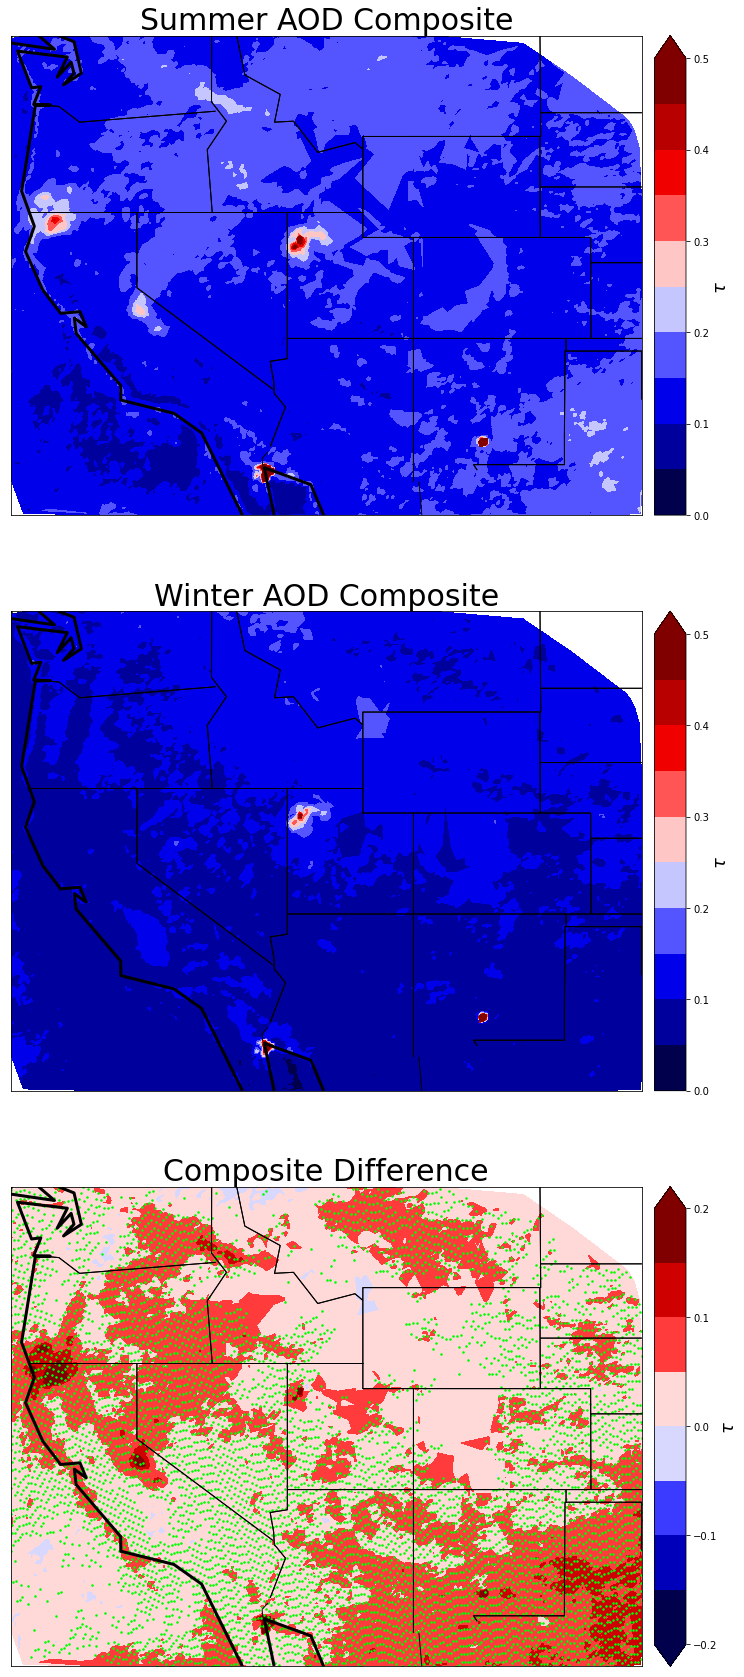

In [188]:
m = Basemap(projection='cyl',llcrnrlon=-125,llcrnrlat=30,urcrnrlon=-100,urcrnrlat=49)

cmap = plt.get_cmap('seismic', lut=10)
clevs = np.arange(0, 0.55, 0.05)

x, y = m(wrf_lons[loc], wrf_lats[loc])
fig, ax = plt.subplots(3, 1, figsize=(15,30))

c1 = m.contourf(x, y, comp1s[0], clevs, extend='max', cmap=cmap, ax=ax[0], tri=True)
cbar1 = m.colorbar(c1, ticks = np.arange(0, 0.6, 0.1), ax=ax[0])
cbar1.ax.set_ylabel(r'$\tau$', weight='bold', name='Calibri', size=18, style='italic')
m.drawcoastlines(linewidth=3, ax=ax[0])
m.drawstates(linewidth=1, ax=ax[0])
ax[0].set_title('Summer AOD Composite', fontdict = {'fontsize' : 30})


c2 = m.contourf(x, y, comp2s[0], clevs, extend='max', cmap=cmap, ax=ax[1], tri=True)
cbar2 = m.colorbar(c2, ticks = np.arange(0, 0.6, 0.1), ax=ax[1])
cbar2.ax.set_ylabel(r'$\tau$', weight='bold', name='Calibri', size=18, style='italic')
m.drawcoastlines(linewidth=3, ax=ax[1])
m.drawstates(linewidth=1, ax=ax[1])
ax[1].set_title('Winter AOD Composite', fontdict = {'fontsize' : 30})

cmap = plt.get_cmap('seismic', lut=14)
clevs = np.arange(-0.2, 0.25, 0.05)

c3 = m.contourf(x, y, compdiffs[0], clevs, extend='both', cmap=cmap, ax=ax[2], tri=True)
cbar3 = m.colorbar(c3, ticks = np.arange(-0.2, 0.3, 0.1), ax=ax[2])
cbar3.ax.set_ylabel(r'$\tau$', weight='bold', name='Calibri', size=18, style='italic')
m.plot(x[sigs.astype(bool)[0]][::3], y[sigs.astype(bool)[0]][::3], 'o', color='lime', markersize=1.5)
m.drawcoastlines(linewidth=3, ax=ax[2])
m.drawstates(linewidth=1, ax=ax[2])
ax[2].set_title('Composite Difference', fontdict = {'fontsize' : 30})

In [ ]:
# import sys
# sys.getrefcount(aod)
# sys.getrefcount(lur)
del aod
del lur
# del dg
# del gridded_data
# del gridded_data2
# del wrf
# del grid2
# del grid2wrf_map2
# del dists2
# del data_s

In [ ]:
#print(d)
#d.drop('GRID_ID', axis=1, inplace=True)
dg = d.groupby(['date', 'Grid_Cell']).first()

In [6]:
with open('data_grouped.txt', 'wb') as fh:
    pickle.dump(d, fh)

In [126]:
with open('data_grouped.txt', 'rb') as file:
    
    d = pickle.load(file)

In [8]:
c = []
for x in [1,2,3]:
    c = c + [x]
c

[1, 2, 3]

In [38]:
d1 = d.drop(['Grid_Cell','date','GRID_ID'], axis=1) 
print(d1)

d1_min = d1.min(axis=0)
d1_range = (d1.max(axis=0) - d1_min)
print(d1_min)
print(d1_range)

d2 = ((d1 - d1_min) / d1_range * 10) + 10
print(d2)

data_ndjf_1 = d2.loc[(d['date'].dt.year == 2013) & (d['date'].dt.month <= 2)].values.reshape((-1,wrf.shape[0],d1.shape[1]))
data_ndjf_2 = d2.loc[((d['date'].dt.month >= 11) & (d['date'].dt.year == 2013))
                     | ((d['date'].dt.month <= 2) & (d['date'].dt.year == 2014))].values.reshape((-1,wrf.shape[0],d1.shape[1]))
data_ndjf_3 = d2.loc[(d['date'].dt.month >= 11) & (d['date'].dt.year == 2014)].values.reshape((-1,wrf.shape[0],d1.shape[1]))
data_jas_1 = d2.loc[(d['date'].dt.month >= 7) & (d['date'].dt.month <= 9) & (d['date'].dt.year == 2013)].values.reshape((-1,wrf.shape[0],d1.shape[1]))
data_jas_2 = d2.loc[(d['date'].dt.month >= 7) & (d['date'].dt.month <= 9) & (d['date'].dt.year == 2014)].values.reshape((-1,wrf.shape[0],d1.shape[1]))

            T_2m_Avg  Dwt_2m_Avg  Ws_10m_Avg  Wdir_10m_Avg       Pmsl_Avg  \
0         289.785004  286.942902    4.506738    348.483063  102353.875000   
1         289.768555  286.952606    4.500871    347.508301  102354.750000   
2         289.774170  286.945587    4.494429    346.438812  102352.367188   
3         289.762939  286.962921    4.503541    345.057159  102354.632812   
4         289.710785  287.009064    4.515438    343.993866  102355.507812   
...              ...         ...         ...           ...            ...   
22803005  259.341553  254.615280    6.263021    268.273865   94411.523438   
22803006  259.272583  254.562668    7.244837    266.981323   93590.742188   
22803007  259.498749  254.753677    7.380472    265.090881   95714.968750   
22803008  259.641022  254.756165    6.342928    268.247650   94357.664062   
22803009  259.747681  254.725235    7.241125    266.981354   93645.585938   

          Veg_Avg  PM_FRM_mod  Albedo_560         HGT           Dist  ...  

In [16]:
d1.columns

Index(['T_2m_Avg', 'Dwt_2m_Avg', 'Ws_10m_Avg', 'Wdir_10m_Avg', 'Pmsl_Avg',
       'Veg_Avg', 'PM_FRM_mod', 'Albedo_560', 'HGT', 'Dist', 'RH', 'PBLH',
       'FRP', 'NH3', 'SO2', 'NOx', 'Pop_den', 'aod_550_x', 'PIH_x', 'lat',
       'lon', 'aod_550_y', 'PIH_y', 'aod_550', 'pih'],
      dtype='object')

In [11]:
print(data_ndjf_1.shape, data_ndjf_2.shape, data_ndjf_3.shape)
print(data_jas_1.shape, data_jas_2.shape)

(59, 31237, 25) (120, 31237, 25) (61, 31237, 25)
(92, 31237, 25) (92, 31237, 25)


In [90]:
data_ndjf_grid_1 = np.moveaxis(data_ndjf_1[:,wrf2grid_map,:], 3, 1)
data_ndjf_grid_2 = np.moveaxis(data_ndjf_2[:,wrf2grid_map,:], 3, 1)
data_ndjf_grid_3 = np.moveaxis(data_ndjf_3[:,wrf2grid_map,:], 3, 1)
data_jas_grid_1 = np.moveaxis(data_jas_1[:,wrf2grid_map,:], 3, 1)
data_jas_grid_2 = np.moveaxis(data_jas_2[:,wrf2grid_map,:], 3, 1)
print(data_ndjf_grid_1.shape, data_ndjf_grid_2.shape, data_ndjf_grid_3.shape)
print(data_jas_grid_1.shape, data_jas_grid_2.shape)

(59, 25, 159, 209) (120, 25, 159, 209) (61, 25, 159, 209)
(92, 25, 159, 209) (92, 25, 159, 209)


In [129]:
del wrf
del wrf2grid_map
del d
del d1
del data_ndjf_2013
del data_jas_2013
del data_ndjf_2014
del data_jas_2014

In [130]:
print(np.nanmin(data_ndjf_grid[:,17,:,:]), np.nanmax(data_ndjf_grid[:,17,:,:]))

0.0 3.742000102996826


In [40]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

In [ ]:
lol = np.arange(54).reshape((3,2,3,3))
time_ids = np.array([0,2])


In [ ]:
np.where(np.array([6,17]) == 17)[0][0]

In [ ]:
del data_ndjf_padded
del label_ids_ndjf
del r
del offset_h
del offset_w
del time_ids
del col_ids
del window_h_ids
del window_w_ids

In [ ]:
window_size = 3
lag = 1
colnames = d1.columns
#print(colnames)
nan_value = -10
data_ndjf_padded = np.pad(data_ndjf_grid, 
                          ((0,0), (0,0), (window_size // 2, window_size // 2), (window_size // 2, window_size // 2)),
                          constant_values=nan_value)
data_ndjf_padded = np.nan_to_num(data_ndjf_padded, nan=nan_value)
#print(data_ndjf_padded.shape)
label_ids_ndjf = (data_ndjf_padded[lag:,17,:,:] != nan_value).nonzero()
#print(label_ids_ndjf[0].size)
#print((~np.isnan(data_ndjf_grid[lag:,17,:,:])).nonzero()[0].size)
r = np.arange(-(window_size // 2), (window_size // 2) + 1)
offset_h = np.tile(r.reshape((-1,1)), window_size)
offset_w = np.tile(r, (window_size, 1))
#print(offset_h)
#print(offset_w)
time_ids = np.tile(np.stack([label_ids_ndjf[0] + i for i in range(lag + 1)], axis=-1), 2).reshape((-1,(lag+1)*2,1,1))
print(time_ids)
print(time_ids.shape)
col_ids = np.repeat(np.array([6,17]), lag+1).reshape((1,-1,1,1))
window_h_ids = label_ids_ndjf[1].reshape((-1,1,1,1)) + offset_h
window_w_ids = label_ids_ndjf[2].reshape((-1,1,1,1)) + offset_w
print(window_h_ids.shape)
print(window_w_ids.shape)
print(col_ids.shape)
# cmaq = data_ndjf_padded[time_ids,6,window_h_ids,window_w_ids]
# aod = data_ndjf_padded[time_ids,17,window_h_ids,window_w_ids]
# aod[:,1,window_size // 2, window_size // 2] = nan_value
# X = np.concatenate((cmaq,aod), axis=1)
# X = data_ndjf_padded[time_ids,col_ids,window_h_ids,window_w_ids]
# loc = ((np.where(np.array([6,17]) == 17)[0][0] + 1) * (lag + 1)) - 1
# print(loc)
# X[:,loc,window_size//2,window_size//2] = nan_value
# print(X.shape)
# print(X)
# Y = data_ndjf_padded[label_ids_ndjf[0]+lag,17,label_ids_ndjf[1],label_ids_ndjf[2]]
# print(Y.shape)
# print(Y)

In [62]:
class AodDataset(Dataset):
    def __init__(self,
                 data,
                 Y_col=23,
                 X_cols=[6,23],
                 window_size=11,
                 lag=1,
                 nan_value=0,
                 dropout=True,
                 test=False):
        self.test = test
        self.window_size = window_size
        self.lag = lag
        self.Y_col = Y_col
        self.nan_value = nan_value
        self.window_size = window_size
            
        self.data_padded = np.pad(data.astype(np.float32), 
                             ((0,0), (0,0), (window_size // 2, window_size // 2), (window_size // 2, window_size // 2)),
                             constant_values=nan_value)
        self.X_cols = np.array(X_cols)        
        if test:
            self.label_ids = (np.isnan(self.data_padded[lag:,Y_col,:,:])).nonzero()
            self.data_padded = np.nan_to_num(self.data_padded, nan=nan_value)
        else:
            self.data_padded = np.nan_to_num(self.data_padded, nan=nan_value)
            self.label_ids = (self.data_padded[lag:,Y_col,:,:] != nan_value).nonzero()
        r = np.arange(-(window_size // 2), (window_size // 2) + 1)
        self.offset_h = np.tile(r.reshape((-1,1)), window_size)
        self.offset_w = np.tile(r, (window_size, 1))
        self.time_ids = np.tile(np.stack([self.label_ids[0] + i for i in range(lag + 1)], axis=-1), len(X_cols)).reshape((-1,(lag+1)*len(X_cols),1,1))
        self.window_h_ids = self.label_ids[1]
        self.window_w_ids = self.label_ids[2]
        self.col_ids = np.repeat(X_cols, lag+1).reshape((-1,1,1))
        
        
    def __len__(self):
        return self.time_ids.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        id0 = self.time_ids[idx]
        id1 = self.col_ids
        id2 = self.window_h_ids[idx].reshape((-1,1,1)) + self.offset_h
        id3 = self.window_w_ids[idx].reshape((-1,1,1)) + self.offset_w
        X = self.data_padded[id0,id1,id2,id3]
        if self.Y_col in self.X_cols:
            if len(X.shape) == 4:
                X[:,((np.where(self.X_cols == self.Y_col)[0][0] + 1) * (self.lag + 1)) - 1,self.window_size//2,self.window_size//2] = self.nan_value
                
            elif len(X.shape) == 3:
                X[((np.where(self.X_cols == self.Y_col)[0][0] + 1) * (self.lag + 1)) - 1,self.window_size//2,self.window_size//2] = self.nan_value
            else:
                raise IndexError('Unexpected index shape.')
        
        idx_y = [i[idx] for i in self.label_ids]
        if self.test:
            return X, (idx_y[0]+self.lag,self.Y_col,idx_y[1]-(self.window_size//2),idx_y[2]-(self.window_size//2))
        Y = self.data_padded[idx_y[0]+self.lag,self.Y_col,idx_y[1],idx_y[2]]
        #Y = self.Y[idx]
        #X = self.X[idx]
        return X, Y

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

def get_act(act):
    if act == 'relu':
        return nn.ReLU()
    elif act == 'sigmoid':
        return nn.Sigmoid()
    elif act == 'tanh':
        return nn.Tanh()
    else:
        raise ValueError('Activation not recognized.')

def conv_block(channels_in, channels_out, kernel_size, stride, padding, act):
    return nn.Sequential(nn.Conv2d(channels_in,
                                channels_out,
                                kernel_size=kernel_size,
                                stride=stride,
                                padding=padding),
                         get_act(act))
    

class CNNInterpolator(nn.Module):
    def __init__(self,
                 in_shape=(4,11,11),
                 nlayers=3,
                 nchannels=[4,10,10,10],
                 kernel_size=[3,3,3],
                 stride=[1,1,1],
                 padding=0,
                 conv_act='relu',
                 hidden_size=32,
                 fc_act='relu'):
        super().__init__()
        self.convs = nn.Sequential(*[conv_block(nchannels[i], 
                                nchannels[i+1], 
                                kernel_size=kernel_size[i], 
                                stride=stride[i],
                                padding=padding,
                                act='relu')
                      for i in range(nlayers)])
        self.convd_shapes = [in_shape]
        params = list(zip(nchannels[1:], kernel_size, stride))
        for i in range(nlayers):
            c, k, s = params[i]
            _, h, w = self.convd_shapes[i]
            self.convd_shapes += [(c, (h - k) / s + 1, (w - k) / s + 1)]
        end_size = self.convd_shapes[-1][0] * self.convd_shapes[-1][1] * self.convd_shapes[-1][2]
        assert end_size == int(end_size)
        self.fcs = nn.Sequential(nn.Linear(in_features=int(end_size), out_features=hidden_size),
                                 get_act(fc_act),
                                 nn.Linear(in_features=hidden_size, out_features=1))
        print(self.convd_shapes)
        
    def forward(self, x):
        return torch.flatten(self.fcs(torch.flatten(self.convs(x), start_dim=1)))

Using cuda device


In [72]:
model = CNNInterpolator(in_shape=(42,11,11), nchannels=[42,42,42,42], hidden_size=1024).to(device)
print(model)

[(42, 11, 11), (42, 9.0, 9.0), (42, 7.0, 7.0), (42, 5.0, 5.0)]
CNNInterpolator(
  (convs): Sequential(
    (0): Sequential(
      (0): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
    )
  )
  (fcs): Sequential(
    (0): Linear(in_features=1050, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1, bias=True)
  )
)


In [54]:
xd = AodDataset(data_jas_grid_1, window_size=3)
dl = DataLoader(xd, batch_size=2, shuffle=True)
x, y = next(iter(dl))
print(x.shape,y.shape)

(4, 1, 1)
[[[2]]

 [[3]]

 [[2]]

 [[3]]]
(4, 1, 1)
[[[ 6]]

 [[ 6]]

 [[23]]

 [[23]]]
(1, 3, 3)
[[[126 126 126]
  [127 127 127]
  [128 128 128]]]
(1, 3, 3)
[[[124 125 126]
  [124 125 126]
  [124 125 126]]]
(4, 1, 1)
[[[34]]

 [[35]]

 [[34]]

 [[35]]]
(4, 1, 1)
[[[ 6]]

 [[ 6]]

 [[23]]

 [[23]]]
(1, 3, 3)
[[[71 71 71]
  [72 72 72]
  [73 73 73]]]
(1, 3, 3)
[[[200 201 202]
  [200 201 202]
  [200 201 202]]]
torch.Size([2, 4, 3, 3]) torch.Size([2])


In [46]:
del data_s1_train
del data_s1_val

In [91]:
data_s1 = AodDataset(data_jas_grid_1, X_cols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,19,20,23,24])
len_t = int(len(data_s1) * 0.8)
len_v = len(data_s1) - len_t
data_s1_train, data_s1_val = random_split(data_s1, [len_t, len_v], generator=torch.Generator().manual_seed(42))

data_s2 = AodDataset(data_jas_grid_2, X_cols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,19,20,23,24])
len_t = int(len(data_s2) * 0.8)
len_v = len(data_s2) - len_t
data_s2_train, data_s2_val = random_split(data_s2, [len_t, len_v], generator=torch.Generator().manual_seed(42))

data_s_train = ConcatDataset([data_s1_train, data_s2_train])
data_s_val = ConcatDataset([data_s1_val, data_s2_val])

In [92]:
dataloader_s_train = DataLoader(data_s_train, batch_size=64, shuffle=True)
dataloader_s_val = DataLoader(data_s_val, batch_size=64, shuffle=True)

In [68]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            

def val_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    
    test_loss /= num_batches
    print(f"avg loss: {test_loss:>8f}\n")

In [70]:
tf, tl = next(iter(dataloader_s_train))
print(tf.shape)
print(tf)
print(tl.shape)
print(tl)

torch.Size([64, 42, 11, 11])
tensor([[[[2.9405e+02, 2.9431e+02, 2.9501e+02,  ..., 2.8972e+02,
           2.8972e+02, 2.8966e+02],
          [2.9325e+02, 2.9324e+02, 2.9363e+02,  ..., 2.9273e+02,
           2.9022e+02, 2.8973e+02],
          [2.9172e+02, 2.9252e+02, 2.9317e+02,  ..., 2.9219e+02,
           2.8973e+02, 2.8936e+02],
          ...,
          [3.0014e+02, 3.0145e+02, 3.0234e+02,  ..., 2.9779e+02,
           2.9664e+02, 2.9729e+02],
          [3.0143e+02, 3.0215e+02, 3.0254e+02,  ..., 2.9924e+02,
           2.9769e+02, 2.9773e+02],
          [3.0194e+02, 3.0194e+02, 3.0269e+02,  ..., 3.0102e+02,
           2.9871e+02, 2.9825e+02]],

         [[2.9475e+02, 2.9511e+02, 2.9573e+02,  ..., 2.9060e+02,
           2.9060e+02, 2.9075e+02],
          [2.9399e+02, 2.9415e+02, 2.9478e+02,  ..., 2.9314e+02,
           2.9100e+02, 2.9063e+02],
          [2.9253e+02, 2.9349e+02, 2.9432e+02,  ..., 2.9295e+02,
           2.9059e+02, 2.9024e+02],
          ...,
          [3.0145e+02, 3.0286e

In [93]:
lr = 1e-3
epochs = 2
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------")
    train_loop(dataloader_s_train, model, loss_fn, optimizer)
    val_loop(dataloader_s_val, model, loss_fn)
print("Done!")

Epoch 1
-----------------------------
loss: 104.421234  [    0/3071146]
loss: 39.170273  [ 6400/3071146]
loss: 0.315559  [12800/3071146]
loss: 0.076909  [19200/3071146]
loss: 0.166110  [25600/3071146]
loss: 0.069361  [32000/3071146]
loss: 0.062048  [38400/3071146]
loss: 0.093301  [44800/3071146]
loss: 0.112664  [51200/3071146]
loss: 0.059312  [57600/3071146]
loss: 0.043967  [64000/3071146]
loss: 0.062735  [70400/3071146]
loss: 0.088097  [76800/3071146]
loss: 0.070904  [83200/3071146]
loss: 0.034099  [89600/3071146]
loss: 0.061823  [96000/3071146]
loss: 0.047143  [102400/3071146]
loss: 0.062213  [108800/3071146]
loss: 0.060349  [115200/3071146]
loss: 0.147531  [121600/3071146]
loss: 0.155918  [128000/3071146]
loss: 0.039276  [134400/3071146]
loss: 0.113852  [140800/3071146]
loss: 0.048146  [147200/3071146]
loss: 0.051365  [153600/3071146]
loss: 0.058730  [160000/3071146]
loss: 0.054726  [166400/3071146]
loss: 0.060063  [172800/3071146]
loss: 0.101608  [179200/3071146]
loss: 0.063353  [1

In [79]:
del data_s
del data_s_train
del data_s_val
del dataloader_s_train
del dataloader_s_val

In [95]:
data_s_test = AodDataset(data_jas_grid_1, test=True, X_cols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,19,20,23,24])
dataloader_s_test = DataLoader(data_s_test, batch_size=64, shuffle=False)

In [75]:
def test_loop(dataloader, model, arr):    
    with torch.no_grad():
        for X, ids in dataloader:
            X = X.to(device)
            pred = model(X)
            ids = [i.cpu() for i in ids]
            arr[ids[0],ids[1],ids[2],ids[3]] = pred.cpu()
    return arr

In [96]:
data_jas_grid_copy = data_jas_grid_1.astype(np.float32)
data_jas_grid_interp = test_loop(dataloader_s_test, model, data_jas_grid_copy)

In [132]:
b = 23
print(data_jas_grid[b,17])
print(data_jas_grid_interp[b,17])

[[0.08318014 0.06035312 0.0496009  ... 0.2665     0.20710605 0.21100001]
 [0.08318014 0.06035312 0.06035312 ...        nan 0.2308     0.21093571]
 [0.10333838 0.10333838 0.07341304 ... 0.21612501 0.23759559 0.21904032]
 ...
 [0.05403279 0.05403279 0.0571831  ... 0.17456           nan        nan]
 [0.0571831  0.0571831  0.06971154 ... 0.20955172        nan        nan]
 [0.06971154 0.06971154 0.04471233 ... 0.25825           nan        nan]]
[[0.08318014 0.06035312 0.0496009  ... 0.2665     0.20710605 0.21100001]
 [0.08318014 0.06035312 0.06035312 ... 0.22878993 0.2308     0.21093571]
 [0.10333838 0.10333838 0.07341304 ... 0.21612501 0.23759559 0.21904032]
 ...
 [0.05403279 0.05403279 0.0571831  ... 0.17456    0.21036594 0.18280619]
 [0.0571831  0.0571831  0.06971154 ... 0.20955172 0.23184931 0.19248608]
 [0.06971154 0.06971154 0.04471233 ... 0.25825    0.26290801 0.20286378]]


In [131]:
np.size(np.where(np.isnan(data_jas_grid[:,17]))[0])

2442857

In [84]:
m = Basemap(projection='cyl',llcrnrlon=-125,llcrnrlat=30,urcrnrlon=-100,urcrnrlat=49)

cmap = plt.get_cmap('seismic', lut=20)
clevs = np.arange(0, 2.1, 0.1)

In [97]:
for i in range(1, data_jas_grid_1.shape[0]):
    fig, ax = plt.subplots(1, 2, figsize=(50,20), facecolor='w')
    
    x, y = m(grid[1], grid[0])
    cs1 = m.contourf(x, y, ((data_jas_grid_1[i,23] - 10) / 10 * d1_range[23]) + d1_min[23], clevs, extend='max', cmap=cmap, ax=ax[0])
    cbar1 = m.colorbar(cs1, ticks=np.arange(0, 2.2, 0.2), ax=ax[0])
    #cbar1.ax.set_ylabel('AOD', weight='bold', name='Calibri', size=18, style='italic')
    cbar1.ax.tick_params(labelsize=30)
    m.drawcoastlines(linewidth=3, ax=ax[0])
    m.drawstates(linewidth=1, ax=ax[0])
    ax[0].set_title('MODIS AOD', fontdict = {'fontsize' : 50})

    cs2 = m.contourf(x, y, ((data_jas_grid_interp[i,23] - 10) / 10 * d1_range[23]) + d1_min[23], clevs, extend='max', cmap=cmap, ax=ax[1])
    cbar2 = m.colorbar(cs2, ticks=np.arange(0, 2.2, 0.2), ax=ax[1])
    #cbar2.ax.set_ylabel('$\mu$g mm$^{-3}$', weight='bold', name='Calibri', size=18, style='italic')
    cbar2.ax.tick_params(labelsize=30)
    m.drawcoastlines(linewidth=3, ax=ax[1])
    m.drawstates(linewidth=1, ax=ax[1])
    ax[1].set_title('MODIS AOD (interpolated)', fontdict = {'fontsize' : 50})
    
    plt.savefig(f'./images/{i}.png')
    plt.close(fig)

In [80]:
((data_jas_grid_interp[0,23] - 10) / 10 * d1_range[23]) + d1_min[23]

array([[-3.672829 , -3.6751497, -3.6678627, ...,        nan,        nan,
        -3.606727 ],
       [-3.672829 , -3.6751497, -3.6751497, ...,        nan,        nan,
               nan],
       [-3.6602774, -3.6602774, -3.665924 , ...,        nan,        nan,
               nan],
       ...,
       [-3.677739 , -3.677739 , -3.680253 , ...,        nan,        nan,
               nan],
       [-3.680253 , -3.680253 , -3.6812212, ...,        nan,        nan,
               nan],
       [-3.6812212, -3.6812212, -3.680121 , ...,        nan,        nan,
               nan]], dtype=float32)

In [89]:
data_jas_grid_1[0,23]

array([[0.18485032, 0.17864864, 0.19812244, ...,        nan,        nan,
        0.36149999],
       [0.18485032, 0.17864864, 0.17864864, ...,        nan,        nan,
               nan],
       [0.21839337, 0.21839337, 0.20330322, ...,        nan,        nan,
               nan],
       ...,
       [0.17172925, 0.17172925, 0.16501029, ...,        nan,        nan,
               nan],
       [0.16501029, 0.16501029, 0.1624229 , ...,        nan,        nan,
               nan],
       [0.1624229 , 0.1624229 , 0.16536318, ...,        nan,        nan,
               nan]])